In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from s_dbw import S_Dbw
import math

In [2]:
# resets index after selections have been made
def resetindex(data):
    data=data.reset_index()
    data=data.drop('index', axis=1)
    return data

In [3]:
#reduces the data set to the first m iterations
def firstiterations(m,data):
    i=0
    j=0
    n=len(data.index)    
    while i<n:
        if  (data.iat[j,10]>m):
            data=data.drop(i, axis=0)
            i=i+1
        else:
            i=i+1
            j=j+1
    data=resetindex(data)
    return data

In [4]:
# Generate a Series with a specific length, so that all residuals of one parameter combination are in one line
def GenerateSeries(source, Length):
    output=source.iloc[:,[4,5]]
    output=output.drop_duplicates()
    output=resetindex(output)
    for j in range(1, Length+1):
        output[f'ResidualNorm{j}']=0.0
        for i in range(len(output.index)):
            Abfrage=source.query( f"`Droptol`=={output.iat[i,0]} and `Fillfactor`=={output.iat[i,1]} and Iterations=={j}")
            if len(Abfrage.index)==1:
                output.iat[i,j+1]=Abfrage.iat[0,8]
            elif len(Abfrage.index)>1:
                raise Exception("Multiple instances with same Droptol, Fillfactor and Iteration within one Beta")
    return output

In [5]:
df=pd.read_csv('PCGDim16129.txt', sep='\t')
df=df.drop('Convergence Mode', axis=1)

beta=1e2
dfBeta=df.query(f"Beta=={beta}")
dfBeta=resetindex(dfBeta)

In [6]:
#test different combinations and compute S_Dbw score
clustermax=12
optimizationgrid=np.zeros(clustermax-2)
SeriesLength=999
series=GenerateSeries(dfBeta,SeriesLength)
scaler = preprocessing.StandardScaler().fit(series.iloc[:,2:(2+SeriesLength)])
scaled_clusterdata=scaler.transform(series.iloc[:,2:(2+SeriesLength)])
for clustercount in range(2,clustermax):
    kmeans=KMeans(n_clusters=clustercount)
    y=kmeans.fit_predict(scaled_clusterdata)
    UnsortedClusters=y
    labels=kmeans.labels_
    score = S_Dbw(scaled_clusterdata, labels, centers_id=None, method='Halkidi', alg_noise='bind', centr='mean', nearest_centr=True, metric='euclidean')
    optimizationgrid[clustercount-2]=score

In [7]:
       
# take best option based on the score      
minima=np.argwhere((optimizationgrid == np.min(optimizationgrid)))
minima=minima[0]
clustercount=minima[0]+2
series=GenerateSeries(dfBeta,SeriesLength)
scaler = preprocessing.StandardScaler().fit(series.iloc[:,2:(2+SeriesLength)])
scaled_clusterdata=scaler.transform(series.iloc[:,2:(2+SeriesLength)])
kmeans=KMeans(n_clusters=clustercount)
y=kmeans.fit_predict(scaled_clusterdata)
UnsortedClusters=y
labels=kmeans.labels_
score = S_Dbw(scaled_clusterdata, labels, centers_id=None, method='Halkidi', alg_noise='bind', centr='mean', nearest_centr=True, metric='euclidean')


#Sort clusters
SortingValues=np.zeros(clustercount)
SortData=pd.DataFrame(series[f'ResidualNorm{SeriesLength}'])
SortData['UnsortedClusters']=y
for i in range(0,clustercount):
    ResOfCluster=SortData.query(f'UnsortedClusters=={i}')
    sums=ResOfCluster[f"ResidualNorm{SeriesLength}"].sum()
    if sums==0:
        NonzerosInSeries=0
        for j in range(0,len(ResOfCluster.index)):
            ToBeCounted=series.loc[ResOfCluster.index[j],:]
            NonzerosInSeries= NonzerosInSeries+np.count_nonzero(ToBeCounted, axis=0)
        NonzerosInSeries=NonzerosInSeries/len(ResOfCluster.index)
        SortingValues[i]=-1000+NonzerosInSeries
    else:    
        SortingValues[i]=sums/len(ResOfCluster.index)

    
    
Sorting=np.argsort(np.argsort(SortingValues))
Clusters=np.zeros(shape=len(UnsortedClusters))
for i in range(0,len(Clusters)):
    Clusters[i]=Sorting[UnsortedClusters[i]]
Clusters=np.int_(Clusters)

series['Cluster']=Clusters


In [8]:
SortingValues

array([ 6.40868030e-10,  1.00954800e-04,  4.07507000e-04, -5.71250000e+02,
        1.52417000e-05,  2.63907200e-06, -9.61550000e+02,  1.34450000e-05,
        2.41052857e-14])

In [9]:
minima

array([7])

<br>
<br>
<br>
<strong> Visualizing parameter space

In [10]:
list=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16']
for cl in range(0,clustercount):
    vars()["PredictionGroup"+list[cl]]=series.query(f"`Cluster`=={cl}")

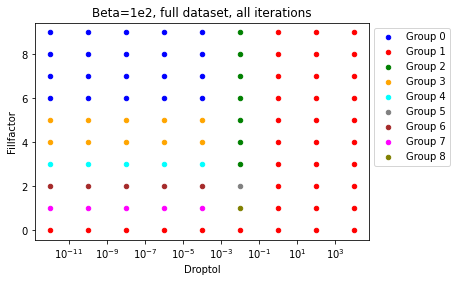

In [11]:
ax = PredictionGroup0.plot(kind='scatter', x='Droptol', y='Fillfactor',color='blue', label='Group 0');
PredictionGroup1.plot(kind='scatter', x='Droptol', y='Fillfactor',color='red', label='Group 1', ax=ax);
if clustercount>2:
    PredictionGroup2.plot(kind='scatter', x='Droptol', y='Fillfactor',color='green', label='Group 2', ax=ax);
    if clustercount>3:
        PredictionGroup3.plot(kind='scatter', x='Droptol', y='Fillfactor',color='orange', label='Group 3', ax=ax);
        if clustercount>4:
            PredictionGroup4.plot(kind='scatter', x='Droptol', y='Fillfactor',color='cyan', label='Group 4', ax=ax);
            if clustercount>5:
                PredictionGroup5.plot(kind='scatter', x='Droptol', y='Fillfactor',color='gray', label='Group 5', ax=ax);
                if clustercount>6:
                    PredictionGroup6.plot(kind='scatter', x='Droptol', y='Fillfactor',color='brown', label='Group 6', ax=ax);
                    if clustercount>7:
                        PredictionGroup7.plot(kind='scatter', x='Droptol', y='Fillfactor',color='magenta', label='Group 7', ax=ax);
                        if clustercount>8:
                            PredictionGroup8.plot(kind='scatter', x='Droptol', y='Fillfactor',color='olive', label='Group 8', ax=ax);
                            if clustercount>9:
                                PredictionGroup9.plot(kind='scatter', x='Droptol', y='Fillfactor',color='black', label='Group 9', ax=ax);
                                if clustercount>10:
                                    PredictionGroup10.plot(kind='scatter', x='Droptol', y='Fillfactor',color='darkorchid', label='Group 10', ax=ax);
                                    if clustercount>11:
                                        PredictionGroup11.plot(kind='scatter', x='Droptol', y='Fillfactor',color='mistyrose', label='Group 11', ax=ax);

ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.title(f"Beta=1e{int(math.log10(beta))}, full dataset, all iterations")
plt.show()

<br>
<br>
<br>
<strong> Visualizing trajectories

In [12]:
dfBeta['Cluster']=0

for i in range(len(dfBeta.index)):
    dfBeta.iat[i,15]=(series.query(f"`Droptol`=={dfBeta.iat[i,4]} and `Fillfactor`=={dfBeta.iat[i,5]}")).iat[0,SeriesLength+2]
    
    
list=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16']
for cl in range(0,clustercount):
    vars()["Group"+list[cl]]=dfBeta.query(f"`Cluster`=={cl}")
    
    

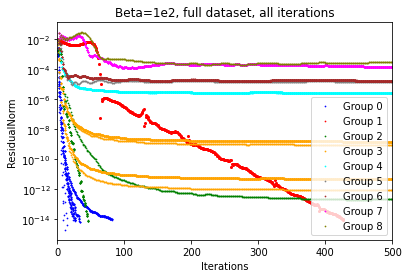

In [13]:
ax = Group0.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='blue', label='Group 0',s=0.5);
Group1.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='red', label='Group 1',ax=ax,s=0.5);
if clustercount>2:
    Group2.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='green', label='Group 2',ax=ax,s=0.5);
    if clustercount>3:
        Group3.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='orange', label='Group 3',ax=ax,s=0.5);
        if clustercount>4:
            Group4.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='cyan', label='Group 4',ax=ax,s=0.5);
            if clustercount>5:
                Group5.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='gray', label='Group 5', ax=ax,s=0.5);
                if clustercount>6:
                    Group6.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='brown', label='Group 6', ax=ax,s=0.5);
                    if clustercount>7:
                        Group7.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='magenta', label='Group 7', ax=ax,s=0.5);
                        if clustercount>8:
                            Group8.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='olive', label='Group 8', ax=ax,s=0.5);
                            if clustercount>9:
                                Group9.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='black', label='Group 9', ax=ax,s=0.5);
                                if clustercount>10:
                                    Group10.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='darkorchid', label='Group 10', ax=ax,s=0.5);
                                    if clustercount>11:
                                        Group11.plot(kind='scatter', x='Iterations', y='ResidualNorm',color='mistyrose', label='Group 11', ax=ax,s=0.5);
                                
ax.set_yscale('log')
ax.set_xlim(0,500)
plt.legend(loc='lower right')
plt.title(f"Beta=1e{int(math.log10(beta))}, full dataset, all iterations")
plt.show() 